In [ ]:
##only run this code on colab
! pip install neurodiffeq

In [2]:
#only run this on colab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path
sys.path.append('drive/MyDrive/PINN/PINN_program/code/train')
print(sys.path)

Mounted at /content/drive
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', 'drive/MyDrive/PINN/PINN_program/code/train']


In [3]:
##this file defines all utility functions to use to train a multihead
##neural network to solve a series of PDEs of one form
from Fisher_models import *

#import all required packages
import torch
import torch.nn as nn
import torch.nn.functional as F

from neurodiffeq import diff
from neurodiffeq.neurodiffeq import unsafe_diff as unsafe_diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D, BundleIVP, BundleDirichletBVP
from neurodiffeq.solvers import Solver1D, Solver2D, BundleSolver1D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D, Generator2D

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import time
from tqdm.auto import tqdm

## Fisher's Equation
We are interested in solving the following Fisher's Equation:

$$\frac{\partial u}{\partial t} - D\frac{\partial^2 u }{\partial x^2} - ru(1-u) = f(x, t)$$

with constant boundary conditions: $u(x, 0) = u(0, t) = u(1, t) = b$ and D is a constant, which we fixed at 1 for now.

Assuming $u ≈ \sum_{i=0}^p r^i u_i$, the above PDE can be reduced to a series of linear PDEs:

$$\frac{\partial u_i}{\partial t}- D\frac{\partial ^2 u_i}{\partial x^2} = f_i$$

The forcing function depends on the solutions of previously solved $u_i$. Our task is to train a multiheaded neural network to learn the hidden state of the above form of PDE.

To facilatate the training on the 16 heads. We used manufactured solutions. We enforce that:

$$u(x, t) = Asin(k_1\pi x) sin(k_2\pi t)+b$$

With corresponding forcing functions:

$$f(x, t) = Ak_2\pi sin(k_1\pi x) cos(k_2 \pi t) + AD\pi^2 k_1^2sin(k_1\pi x)sin(k_2 \pi t)$$

In our implementation, we fixed b = 0.5 and let A vary in [0.5, -0.5] and let $k_2$ vary evenly in interval [1, 2].

In [4]:
##construct a model of 16 heads
k=16
model = Multihead_model(k=k, act = nn.functional.silu, bias=True)
model

Multihead_model(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=512, bias=True)
  (final_layers): ModuleList(
    (0-15): 16 x Linear(in_features=256, out_features=1, bias=True)
  )
)

In [5]:
k1 = 2
K2 = np.linspace(1, 2, 8)
A_list = [0.5, -0.5]; b = 0.5; k=16

truth_functions = []; Forcing_functions = []

for k2 in K2:
  for A in A_list:
    truth_functions.append(truth_decorator_trig(A, k1, k2, b=b))
    Forcing_functions.append(forcing_decorator_trig(A, k1, k2, D=1))

#compute the truth solution
truth_solution = [truth_functions[i](X_grid[:,0],
                            X_grid[:,1]).cpu().detach().numpy().reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]

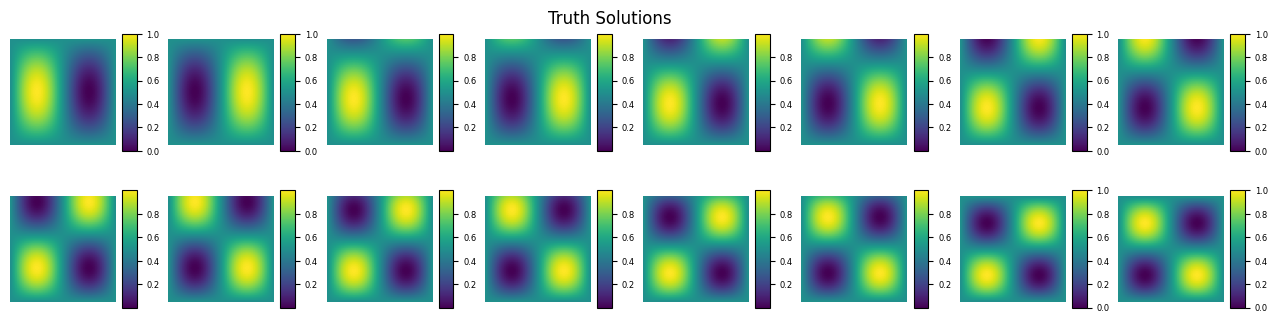

In [6]:
plot_solutions16(truth_solution, 'Truth Solutions');

In [7]:
##train the network
b = 0.5
learning_rate = 1e-3 ##initial learning rate
num_iter= 20000 ##number of iterations
step_size = 100 ##how often the exponential decay is applied
gamma = 0.98 ##exponential decay scale

##define the sampling parameters
interior_grid = (50, 50)
x_boundary_num = 100
t_boundary_num = 100 #on both t boundaries
#define boundary condition
boundary_value = b
##define smapling method
method='equally-spaced-noisy'

##define the weights in each component of the loss
pde_weight = 1; bc_weight = 1; data_weight = 1

##define the optimizer
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
##define the exponential learning rate decay scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
##train the model
loss_trace, pde_trace, bc_trace, data_trace = train(model, optimizer, loss, num_iter, Forcing_functions, truth_functions,
          boundary_value, D = 1, interior_grid=interior_grid, x_boundary_num=x_boundary_num, t_boundary_num=t_boundary_num,
          every=100, pde_weight=pde_weight, bc_weight=bc_weight, data_weight=data_weight, scheduler=scheduler, method=method)

  0%|          | 100/20000 [00:31<1:47:18,  3.09it/s]

100th Iter: total 19.804748936528913, pde 19.74491267121957, bc 0.006386387733067238, data 0.05344987757627862


  1%|          | 200/20000 [01:01<1:42:48,  3.21it/s]

200th Iter: total 7.2993678043024826, pde 7.195256434430109, bc 0.05805283990020812, data 0.046058529972165224


  2%|▏         | 300/20000 [01:31<1:35:38,  3.43it/s]

300th Iter: total 0.7652319511226343, pde 0.7057373771925732, bc 0.03975420741995084, data 0.01974036651011019


  2%|▏         | 400/20000 [02:00<1:35:33,  3.42it/s]

400th Iter: total 0.5799018270526681, pde 0.5312958909745857, bc 0.0315769718272882, data 0.017028964250794098


  2%|▎         | 500/20000 [02:31<1:39:34,  3.26it/s]

500th Iter: total 0.3462026530561516, pde 0.3087501184298254, bc 0.02314111602969047, data 0.014311418596635707


  3%|▎         | 600/20000 [03:01<1:38:24,  3.29it/s]

600th Iter: total 0.13682368784428806, pde 0.11730981636724219, bc 0.012965362490378834, data 0.006548508986667042


  4%|▎         | 700/20000 [03:32<1:37:05,  3.31it/s]

700th Iter: total 0.14316565704343204, pde 0.12924327263550417, bc 0.008923682838368014, data 0.004998701569559861


  4%|▍         | 800/20000 [04:03<1:41:00,  3.17it/s]

800th Iter: total 0.07684097001986993, pde 0.068592861060297, bc 0.005582881276217933, data 0.0026652276833550076


  4%|▍         | 900/20000 [04:33<1:33:32,  3.40it/s]

900th Iter: total 0.09387229015446424, pde 0.08732063577311006, bc 0.004166917791006458, data 0.002384736590347724


  5%|▌         | 1000/20000 [05:03<1:33:34,  3.38it/s]

1000th Iter: total 0.04903934056352617, pde 0.04474394354409339, bc 0.0030361275758192335, data 0.0012592694436135493


  6%|▌         | 1100/20000 [05:33<1:33:12,  3.38it/s]

1100th Iter: total 0.05232207691091062, pde 0.04883832704261884, bc 0.0024758484687851788, data 0.0010079013995066034


  6%|▌         | 1200/20000 [06:03<1:41:29,  3.09it/s]

1200th Iter: total 0.1158757310398625, pde 0.11135444795967538, bc 0.002473795049435095, data 0.002047488030752028


  6%|▋         | 1300/20000 [06:33<1:36:01,  3.25it/s]

1300th Iter: total 0.057541357623549796, pde 0.054591346292193435, bc 0.0019030499749518419, data 0.0010469613564045134


  7%|▋         | 1400/20000 [07:04<1:31:25,  3.39it/s]

1400th Iter: total 0.11306333929486564, pde 0.10970021090796118, bc 0.001860016242596289, data 0.0015031121443081757


  8%|▊         | 1500/20000 [07:33<1:36:05,  3.21it/s]

1500th Iter: total 0.08605911317746488, pde 0.0833213482432181, bc 0.0016614945541729791, data 0.0010762703800738006


  8%|▊         | 1600/20000 [08:04<1:28:36,  3.46it/s]

1600th Iter: total 0.30878667894023776, pde 0.3030481320505701, bc 0.0024401996119110896, data 0.0032983472777565687


  8%|▊         | 1700/20000 [08:34<1:30:39,  3.36it/s]

1700th Iter: total 0.019603002125075413, pde 0.017895208560882326, bc 0.0013004836515995754, data 0.0004073099125935124


  9%|▉         | 1800/20000 [09:03<1:29:19,  3.40it/s]

1800th Iter: total 0.01931044177261586, pde 0.017580028048749512, bc 0.001283358360809667, data 0.0004470553630566798


 10%|▉         | 1900/20000 [09:34<1:33:23,  3.23it/s]

1900th Iter: total 0.015784519944828584, pde 0.014274555640538077, bc 0.0011792794268221888, data 0.0003306848774683175


 10%|█         | 2000/20000 [10:04<1:30:07,  3.33it/s]

2000th Iter: total 0.015438794926745372, pde 0.013991972819299685, bc 0.0011245461002004793, data 0.00032227600724520756


 10%|█         | 2100/20000 [10:34<1:27:32,  3.41it/s]

2100th Iter: total 0.0648001238889609, pde 0.06272381671867443, bc 0.0012377244163198342, data 0.0008385827539666395


 11%|█         | 2200/20000 [11:03<1:28:41,  3.34it/s]

2200th Iter: total 0.04357111796408787, pde 0.041879718440945304, bc 0.001140325172695171, data 0.0005510743504474017


 12%|█▏        | 2300/20000 [11:34<1:30:20,  3.27it/s]

2300th Iter: total 0.06332528241629752, pde 0.06151706448958892, bc 0.0011346633415983344, data 0.0006735545851102654


 12%|█▏        | 2400/20000 [12:04<1:27:16,  3.36it/s]

2400th Iter: total 0.09700000018547712, pde 0.0943663936233375, bc 0.0013921446302472152, data 0.0012414619318924112


 12%|█▎        | 2500/20000 [12:33<1:25:23,  3.42it/s]

2500th Iter: total 0.02819203989010891, pde 0.02676221111610221, bc 0.0010172749286130253, data 0.00041255384539367305


 13%|█▎        | 2600/20000 [13:03<1:26:47,  3.34it/s]

2600th Iter: total 0.12603716875274237, pde 0.12343827736870522, bc 0.0012852681295447358, data 0.0013136232544924136


 14%|█▎        | 2700/20000 [13:33<1:25:08,  3.39it/s]

2700th Iter: total 0.034727671136880106, pde 0.033253782336889845, bc 0.00103023759868136, data 0.0004436512013089022


 14%|█▍        | 2800/20000 [14:03<1:23:17,  3.44it/s]

2800th Iter: total 0.03512543620491453, pde 0.03372461507035671, bc 0.000999256523352572, data 0.0004015646112052485


 14%|█▍        | 2900/20000 [14:34<1:22:55,  3.44it/s]

2900th Iter: total 0.009287290576178168, pde 0.00816192802850267, bc 0.0009116580527875614, data 0.0002137044948879369


 15%|█▌        | 3000/20000 [15:04<1:27:03,  3.25it/s]

3000th Iter: total 0.008792273697823146, pde 0.007702998806621314, bc 0.0008807886219165692, data 0.00020848626928526373


 16%|█▌        | 3100/20000 [15:34<1:24:07,  3.35it/s]

3100th Iter: total 0.009706426907314294, pde 0.008584667926954854, bc 0.0009054588953519785, data 0.0002163000850074627


 16%|█▌        | 3200/20000 [16:04<1:23:51,  3.34it/s]

3200th Iter: total 0.01353857318573708, pde 0.012355161054782678, bc 0.0009114324472632479, data 0.00027197968369115506


 16%|█▋        | 3300/20000 [16:34<1:23:25,  3.34it/s]

3300th Iter: total 0.014083665449551214, pde 0.012909684283824172, bc 0.0008912792350806391, data 0.000282701930646404


 17%|█▋        | 3400/20000 [17:04<1:21:28,  3.40it/s]

3400th Iter: total 0.008342544447705593, pde 0.007282260678135481, bc 0.0008589374372939896, data 0.00020134633227612302


 18%|█▊        | 3500/20000 [17:34<1:20:39,  3.41it/s]

3500th Iter: total 0.008960677849797568, pde 0.007913075494109098, bc 0.0008456995898800798, data 0.00020190276580839088


 18%|█▊        | 3600/20000 [18:05<1:20:15,  3.41it/s]

3600th Iter: total 0.04083529680163072, pde 0.03931646256154605, bc 0.0009693680735240068, data 0.0005494661665606679


 18%|█▊        | 3700/20000 [18:34<1:21:15,  3.34it/s]

3700th Iter: total 0.04153328500929516, pde 0.04018118039952274, bc 0.0009153019044556503, data 0.0004368027053167685


 19%|█▉        | 3800/20000 [19:05<1:20:24,  3.36it/s]

3800th Iter: total 0.11180436326929505, pde 0.10797929884571861, bc 0.001859652983615179, data 0.001965411439961269


 20%|█▉        | 3900/20000 [19:35<1:20:44,  3.32it/s]

3900th Iter: total 0.005955488826654246, pde 0.0049992833582026, bc 0.0007937483593413921, data 0.0001624571091102543


 20%|██        | 4000/20000 [20:05<1:25:08,  3.13it/s]

4000th Iter: total 0.006136934041704857, pde 0.00518471787147314, bc 0.0007872976028242292, data 0.00016491856740748722


 20%|██        | 4100/20000 [20:35<1:17:41,  3.41it/s]

4100th Iter: total 0.008903968793816747, pde 0.007891659046240073, bc 0.0007974999027679005, data 0.0002148098448087736


 21%|██        | 4200/20000 [21:06<1:32:57,  2.83it/s]

4200th Iter: total 0.005407045982675794, pde 0.004486931543209146, bc 0.0007640658953779816, data 0.00015604854408866737


 22%|██▏       | 4300/20000 [21:36<1:21:36,  3.21it/s]

4300th Iter: total 0.02645421028787081, pde 0.02531652018526088, bc 0.0008129705544302795, data 0.00032471954817964806


 22%|██▏       | 4400/20000 [22:06<1:16:39,  3.39it/s]

4400th Iter: total 0.005118829075338211, pde 0.004223024073503682, bc 0.000742023648267867, data 0.000153781353566662


 22%|██▎       | 4500/20000 [22:36<1:15:52,  3.40it/s]

4500th Iter: total 0.0051343821425967, pde 0.004228356685902405, bc 0.0007499620079618331, data 0.00015606344873246187


 23%|██▎       | 4600/20000 [23:05<1:16:40,  3.35it/s]

4600th Iter: total 0.007027123856071209, pde 0.0061420385922816975, bc 0.0007241594127499732, data 0.00016092585103953807


 24%|██▎       | 4700/20000 [23:35<1:18:40,  3.24it/s]

4700th Iter: total 0.004580013558568748, pde 0.0037300192811073915, bc 0.0007126061833070052, data 0.00013738809415435137


 24%|██▍       | 4800/20000 [24:05<1:15:55,  3.34it/s]

4800th Iter: total 0.005281570123207982, pde 0.004436684250864468, bc 0.0006975748226602686, data 0.00014731104968324568


 24%|██▍       | 4900/20000 [24:36<1:20:13,  3.14it/s]

4900th Iter: total 0.0046258277201772675, pde 0.003761482357772905, bc 0.0007108548811802693, data 0.0001534904812240925


 25%|██▌       | 5000/20000 [25:06<1:14:08,  3.37it/s]

5000th Iter: total 0.00437435936870234, pde 0.0035582900642610014, bc 0.0006810400341939503, data 0.00013502927024738824


 26%|██▌       | 5100/20000 [25:36<1:12:24,  3.43it/s]

5100th Iter: total 0.00676905608012219, pde 0.005923731131991838, bc 0.0006747007082877147, data 0.00017062423984263726


 26%|██▌       | 5200/20000 [26:06<1:11:37,  3.44it/s]

5200th Iter: total 0.00405236669710603, pde 0.0032576932349301906, bc 0.0006654062154262699, data 0.00012926724674956945


 26%|██▋       | 5300/20000 [26:36<1:14:20,  3.30it/s]

5300th Iter: total 0.05175307409938818, pde 0.050524018473688634, bc 0.0007787382566805095, data 0.00045031736901903613


 27%|██▋       | 5400/20000 [27:06<1:12:16,  3.37it/s]

5400th Iter: total 0.004412866864672826, pde 0.0036325161264421342, bc 0.0006475844547503522, data 0.00013276628348033947


 28%|██▊       | 5500/20000 [27:36<1:17:36,  3.11it/s]

5500th Iter: total 0.009127068553589893, pde 0.008247954162259518, bc 0.0006818327610536633, data 0.00019728163027671198


 28%|██▊       | 5600/20000 [28:06<1:15:24,  3.18it/s]

5600th Iter: total 0.0035682095375740384, pde 0.0028301898679023744, bc 0.00062508380651654, data 0.00011293586315512383


 28%|██▊       | 5700/20000 [28:36<1:08:06,  3.50it/s]

5700th Iter: total 0.019292040603545422, pde 0.018417987205438597, bc 0.000668082232688393, data 0.00020597116541843212


 29%|██▉       | 5800/20000 [29:06<1:09:06,  3.42it/s]

5800th Iter: total 0.005298098102428283, pde 0.004556346853441206, bc 0.0006091983291349798, data 0.00013255291985209757


 30%|██▉       | 5900/20000 [29:37<1:08:42,  3.42it/s]

5900th Iter: total 0.003549803629798694, pde 0.002830253044909529, bc 0.0006025725284308971, data 0.00011697805645826796


 30%|███       | 6000/20000 [30:07<1:08:07,  3.43it/s]

6000th Iter: total 0.003648070698610139, pde 0.002953626551720851, bc 0.0005842868605090146, data 0.0001101572863802736


 30%|███       | 6100/20000 [30:37<1:11:06,  3.26it/s]

6100th Iter: total 0.003213251416360572, pde 0.0025204108311434156, bc 0.0005837117534777247, data 0.00010912883173943158


 31%|███       | 6200/20000 [31:07<1:10:00,  3.29it/s]

6200th Iter: total 0.005715551250967351, pde 0.005015208549029576, bc 0.0005767399965875311, data 0.0001236027053502442


 32%|███▏      | 6300/20000 [31:37<1:08:56,  3.31it/s]

6300th Iter: total 0.003448734939781952, pde 0.0027780188513332514, bc 0.0005649941820622081, data 0.00010572190638649217


 32%|███▏      | 6400/20000 [32:08<1:06:38,  3.40it/s]

6400th Iter: total 0.0036776462232366376, pde 0.0030131385225644312, bc 0.0005543235728358926, data 0.00011018412783631391


 32%|███▎      | 6500/20000 [32:38<1:05:30,  3.43it/s]

6500th Iter: total 0.003060416372460881, pde 0.002407253260411554, bc 0.0005486837878996526, data 0.00010447932414967436


 33%|███▎      | 6600/20000 [33:08<1:04:27,  3.46it/s]

6600th Iter: total 0.0029367098550018705, pde 0.0023044670797469436, bc 0.0005348843146537502, data 9.735846060117646e-05


 34%|███▎      | 6700/20000 [33:38<1:04:33,  3.43it/s]

6700th Iter: total 0.0032791251024111285, pde 0.0026383085617019105, bc 0.0005354591569402178, data 0.00010535738376900013


 34%|███▍      | 6800/20000 [34:09<1:09:39,  3.16it/s]

6800th Iter: total 0.0030110402962590698, pde 0.0023978741994705034, bc 0.0005169925930552698, data 9.617350373329641e-05


 34%|███▍      | 6900/20000 [34:39<1:03:57,  3.41it/s]

6900th Iter: total 0.006915327282742018, pde 0.006228203205316291, bc 0.000540467142682224, data 0.00014665693474350314


 35%|███▌      | 7000/20000 [35:09<1:06:02,  3.28it/s]

7000th Iter: total 0.003979623248336079, pde 0.003377567346304733, bc 0.0005020960992488204, data 9.995980278252567e-05


 36%|███▌      | 7100/20000 [35:39<1:05:02,  3.31it/s]

7100th Iter: total 0.0026057444515879716, pde 0.0020209819641070904, bc 0.0004980764343626234, data 8.668605311825764e-05


 36%|███▌      | 7200/20000 [36:08<1:03:00,  3.39it/s]

7200th Iter: total 0.007055518094584973, pde 0.006427221837089516, bc 0.0005109048863714607, data 0.00011739137112399539


 36%|███▋      | 7300/20000 [36:38<1:01:36,  3.44it/s]

7300th Iter: total 0.0037511013511162604, pde 0.0031575301320628576, bc 0.0004937831137769202, data 9.978810527648233e-05


 37%|███▋      | 7400/20000 [37:08<1:00:58,  3.44it/s]

7400th Iter: total 0.002892027056976972, pde 0.0023317440703725014, bc 0.0004754785185520702, data 8.480446805240011e-05


 38%|███▊      | 7500/20000 [37:39<1:01:22,  3.39it/s]

7500th Iter: total 0.005261616496806931, pde 0.004680920691247671, bc 0.00047272518694924033, data 0.00010797061861001973


 38%|███▊      | 7600/20000 [38:09<1:06:55,  3.09it/s]

7600th Iter: total 0.0023579564967583623, pde 0.0018163437987659028, bc 0.00046114385433144875, data 8.046884366101041e-05


 38%|███▊      | 7700/20000 [38:40<1:01:14,  3.35it/s]

7700th Iter: total 0.010307891112162418, pde 0.009599450192630785, bc 0.0005210442065420941, data 0.00018739671298953776


 39%|███▉      | 7800/20000 [39:10<1:04:30,  3.15it/s]

7800th Iter: total 0.0022524853584590934, pde 0.0017282883658380833, bc 0.00044655809175272754, data 7.763890086828224e-05


 40%|███▉      | 7900/20000 [39:40<1:00:49,  3.32it/s]

7900th Iter: total 0.0406560594770693, pde 0.03963441667408323, bc 0.0005840834806809127, data 0.0004375593223051571


 40%|████      | 8000/20000 [40:10<58:52,  3.40it/s]

8000th Iter: total 0.0022260427093875996, pde 0.00171394338584591, bc 0.0004347408018517139, data 7.735852168997539e-05


 40%|████      | 8100/20000 [40:41<1:00:51,  3.26it/s]

8100th Iter: total 0.032848698529971916, pde 0.031742932038675065, bc 0.0006324462891243579, data 0.00047332020217249397


 41%|████      | 8200/20000 [41:11<58:53,  3.34it/s]

8200th Iter: total 0.0020978223748075353, pde 0.0016038550158519237, bc 0.0004197578437026125, data 7.420951525299911e-05


 42%|████▏     | 8300/20000 [41:40<56:16,  3.47it/s]

8300th Iter: total 0.0023195753905604286, pde 0.0018307267507173671, bc 0.00041164516132669206, data 7.720347851636958e-05


 42%|████▏     | 8400/20000 [42:10<57:24,  3.37it/s]

8400th Iter: total 0.0021204361070180865, pde 0.0016422174563635744, bc 0.00040840811906215003, data 6.981053159236209e-05


 42%|████▎     | 8500/20000 [42:41<1:01:20,  3.12it/s]

8500th Iter: total 0.0024539556405476616, pde 0.001968941085066543, bc 0.00040567654233643054, data 7.933801314468824e-05


 43%|████▎     | 8600/20000 [43:11<57:28,  3.31it/s]

8600th Iter: total 0.005584562925457036, pde 0.005027449963085301, bc 0.0004287223381901604, data 0.0001283906241815745


 44%|████▎     | 8700/20000 [43:41<59:47,  3.15it/s]

8700th Iter: total 0.004476770339469417, pde 0.003983738013022916, bc 0.00040018002458515686, data 9.28523018613445e-05


 44%|████▍     | 8800/20000 [44:11<55:06,  3.39it/s]

8800th Iter: total 0.0018943320476802264, pde 0.001444083651187533, bc 0.00038325420193406563, data 6.699419455862785e-05


 44%|████▍     | 8900/20000 [44:41<54:52,  3.37it/s]

8900th Iter: total 0.0036120494406798732, pde 0.003135152234812342, bc 0.00039062007679597116, data 8.627712907156049e-05


 45%|████▌     | 9000/20000 [45:10<53:27,  3.43it/s]

9000th Iter: total 0.0018416715265134114, pde 0.0014054518415749712, bc 0.0003727112091301268, data 6.350847580831331e-05


 46%|████▌     | 9100/20000 [45:40<56:24,  3.22it/s]

9100th Iter: total 0.009943734049352405, pde 0.009424768182995922, bc 0.00038696697818183505, data 0.00013199888817464806


 46%|████▌     | 9200/20000 [46:10<52:25,  3.43it/s]

9200th Iter: total 0.001749187789571312, pde 0.0013274696350544218, bc 0.0003616178239512473, data 6.0100330565642795e-05


 46%|████▋     | 9300/20000 [46:40<53:32,  3.33it/s]

9300th Iter: total 0.001678434869671996, pde 0.0012651675706380073, bc 0.00035649065694083024, data 5.677664209315841e-05


 47%|████▋     | 9400/20000 [47:10<52:27,  3.37it/s]

9400th Iter: total 0.01128399768248802, pde 0.010737443729941594, bc 0.00039226309491096126, data 0.00015429085763546413


 48%|████▊     | 9500/20000 [47:40<51:01,  3.43it/s]

9500th Iter: total 0.00167884383751958, pde 0.0012755591003207332, bc 0.0003452188858213289, data 5.806585137751801e-05


 48%|████▊     | 9600/20000 [48:10<51:16,  3.38it/s]

9600th Iter: total 0.002055250964079436, pde 0.0016485727786328306, bc 0.00034649166251706637, data 6.018652292953893e-05


 48%|████▊     | 9700/20000 [48:40<49:52,  3.44it/s]

9700th Iter: total 0.0023560377543939627, pde 0.0019533043019809796, bc 0.00033729955122455986, data 6.543390118842294e-05


 49%|████▉     | 9800/20000 [49:10<53:20,  3.19it/s]

9800th Iter: total 0.0015804794230541877, pde 0.0011923430124605265, bc 0.0003355984270886532, data 5.253798350500807e-05


 50%|████▉     | 9900/20000 [49:40<52:12,  3.22it/s]

9900th Iter: total 0.002152091451253207, pde 0.0017697039128962417, bc 0.000326704020346325, data 5.5683518010640325e-05


 50%|█████     | 10000/20000 [50:10<49:01,  3.40it/s]

10000th Iter: total 0.0015531460555531765, pde 0.001180829289279151, bc 0.000320683612836184, data 5.163315343784163e-05


 50%|█████     | 10100/20000 [50:40<47:34,  3.47it/s]

10100th Iter: total 0.0020775369610759194, pde 0.001650427947796687, bc 0.00035090818042854725, data 7.620083285068553e-05


 51%|█████     | 10200/20000 [51:10<49:02,  3.33it/s]

10200th Iter: total 0.0015935550569708334, pde 0.0012273213364744726, bc 0.0003110926073449492, data 5.514111315141171e-05


 52%|█████▏    | 10300/20000 [51:39<47:29,  3.40it/s]

10300th Iter: total 0.00947347800561929, pde 0.009002356069441593, bc 0.00034243095849070354, data 0.00012869097768699537


 52%|█████▏    | 10400/20000 [52:09<47:08,  3.39it/s]

10400th Iter: total 0.0015943353897913356, pde 0.0012384158915325419, bc 0.000302943212895965, data 5.2976285362828835e-05


 52%|█████▎    | 10500/20000 [52:39<46:44,  3.39it/s]

10500th Iter: total 0.002317396781136393, pde 0.0019607291598128193, bc 0.0003009383411565016, data 5.5729280167072126e-05


 53%|█████▎    | 10600/20000 [53:09<46:08,  3.40it/s]

10600th Iter: total 0.0014310976736991018, pde 0.0010870554594935712, bc 0.00029451796791995355, data 4.952424628557712e-05


 54%|█████▎    | 10700/20000 [53:39<50:59,  3.04it/s]

10700th Iter: total 0.0017622627951628662, pde 0.0014141596267676498, bc 0.0002931503869981149, data 5.4952781397101604e-05


 54%|█████▍    | 10800/20000 [54:09<49:32,  3.09it/s]

10800th Iter: total 0.0013666497112803024, pde 0.0010341064449001386, bc 0.00028579379878678173, data 4.674946759338224e-05


 55%|█████▍    | 10900/20000 [54:39<44:47,  3.39it/s]

10900th Iter: total 0.003785736743401415, pde 0.0034388755665193736, bc 0.00028595121647780216, data 6.090996040423918e-05


 55%|█████▌    | 11000/20000 [55:09<43:38,  3.44it/s]

11000th Iter: total 0.001706005868634339, pde 0.0013768217686896636, bc 0.0002791628792516257, data 5.002122069304973e-05


 56%|█████▌    | 11100/20000 [55:39<43:26,  3.41it/s]

11100th Iter: total 0.0013709515594813872, pde 0.0010485327427496003, bc 0.00027578077112630934, data 4.663804560547772e-05


 56%|█████▌    | 11200/20000 [56:09<43:43,  3.35it/s]

11200th Iter: total 0.001452862907239118, pde 0.0011359839403549687, bc 0.0002700073853443546, data 4.6871581539794665e-05


 56%|█████▋    | 11300/20000 [56:40<43:06,  3.36it/s]

11300th Iter: total 0.008470834660836393, pde 0.008065046783352616, bc 0.000300470935242952, data 0.00010531694224082473


 57%|█████▋    | 11400/20000 [57:10<42:55,  3.34it/s]

11400th Iter: total 0.0014136050860658273, pde 0.0011052348115646534, bc 0.0002630829267745613, data 4.528734772661246e-05


 57%|█████▊    | 11500/20000 [57:40<41:27,  3.42it/s]

11500th Iter: total 0.0016346290587108524, pde 0.001329534289345318, bc 0.0002600444616616671, data 4.50503077038674e-05


 58%|█████▊    | 11600/20000 [58:11<43:13,  3.24it/s]

11600th Iter: total 0.0013991447545195009, pde 0.001096167405647858, bc 0.00025656418407248456, data 4.6413164799158164e-05


 58%|█████▊    | 11700/20000 [58:41<41:05,  3.37it/s]

11700th Iter: total 0.0012444505383544242, pde 0.0009531974839815174, bc 0.0002518860490903182, data 3.936700528258854e-05


 59%|█████▉    | 11800/20000 [59:11<44:53,  3.04it/s]

11800th Iter: total 0.0025600496923629556, pde 0.002256210127916021, bc 0.00025116422194508553, data 5.267534250184938e-05


 60%|█████▉    | 11900/20000 [59:41<39:45,  3.40it/s]

11900th Iter: total 0.00259268023748354, pde 0.002291187742569698, bc 0.00024725136680156485, data 5.424112811227744e-05


 60%|██████    | 12000/20000 [1:00:11<39:49,  3.35it/s]

12000th Iter: total 0.001155302688635615, pde 0.0008744131811368264, bc 0.00024198459599799504, data 3.8904911500793584e-05


 60%|██████    | 12100/20000 [1:00:41<38:59,  3.38it/s]

12100th Iter: total 0.003419082326728306, pde 0.0031075470998003555, bc 0.00024938323448370653, data 6.215199244424394e-05


 61%|██████    | 12200/20000 [1:01:11<39:20,  3.30it/s]

12200th Iter: total 0.0011302383482820002, pde 0.000856164805918165, bc 0.00023459556454698263, data 3.94779778168527e-05


 62%|██████▏   | 12300/20000 [1:01:41<38:22,  3.34it/s]

12300th Iter: total 0.0012097579516464592, pde 0.0009428918790790168, bc 0.00023102158296009188, data 3.584448960735045e-05


 62%|██████▏   | 12400/20000 [1:02:11<36:28,  3.47it/s]

12400th Iter: total 0.007380966062341521, pde 0.007017012824251165, bc 0.00026255981357065956, data 0.00010139342451969645


 62%|██████▎   | 12500/20000 [1:02:41<37:05,  3.37it/s]

12500th Iter: total 0.001081459814810109, pde 0.0008191962337576392, bc 0.00022541642752823028, data 3.684715352423947e-05


 63%|██████▎   | 12600/20000 [1:03:11<36:12,  3.41it/s]

12600th Iter: total 0.0012323970488578482, pde 0.0009570976273577745, bc 0.00023077987441315058, data 4.4519547086923105e-05


 64%|██████▎   | 12700/20000 [1:03:41<34:55,  3.48it/s]

12700th Iter: total 0.0010466027345327799, pde 0.0007930332483505833, bc 0.00021878143842274015, data 3.4788047759456254e-05


 64%|██████▍   | 12800/20000 [1:04:11<34:45,  3.45it/s]

12800th Iter: total 0.0010994533635473916, pde 0.0008439853558886015, bc 0.00021730817135278302, data 3.815983630600719e-05


 64%|██████▍   | 12900/20000 [1:04:41<34:22,  3.44it/s]

12900th Iter: total 0.0012382499673139979, pde 0.0009876557445057386, bc 0.00021461169866929388, data 3.598252413896546e-05


 65%|██████▌   | 13000/20000 [1:05:11<36:07,  3.23it/s]

13000th Iter: total 0.0010519712128930687, pde 0.0008071391017739455, bc 0.00021059603930062833, data 3.423607181849487e-05


 66%|██████▌   | 13100/20000 [1:05:41<35:17,  3.26it/s]

13100th Iter: total 0.0010893148207703851, pde 0.000846937175889027, bc 0.00020739716250098704, data 3.498048238037117e-05


 66%|██████▌   | 13200/20000 [1:06:11<34:19,  3.30it/s]

13200th Iter: total 0.0009792367297916367, pde 0.0007417487157604982, bc 0.00020454109460352267, data 3.294691942761589e-05


 66%|██████▋   | 13300/20000 [1:06:41<33:27,  3.34it/s]

13300th Iter: total 0.0013396867318210296, pde 0.001103049502056145, bc 0.00020179053316093262, data 3.484669660395216e-05


 67%|██████▋   | 13400/20000 [1:07:10<34:02,  3.23it/s]

13400th Iter: total 0.000994919727619837, pde 0.0007592187917027098, bc 0.00020036413109810193, data 3.533680481902521e-05


 68%|██████▊   | 13500/20000 [1:07:40<31:18,  3.46it/s]

13500th Iter: total 0.0012333322486544895, pde 0.0010029137488037348, bc 0.00019733356612558015, data 3.308493372517476e-05


 68%|██████▊   | 13600/20000 [1:08:11<32:14,  3.31it/s]

13600th Iter: total 0.0009767738717495272, pde 0.0007499348307987801, bc 0.00019517655065145459, data 3.166249029929258e-05


 68%|██████▊   | 13700/20000 [1:08:41<30:55,  3.40it/s]

13700th Iter: total 0.00199409325137848, pde 0.0017549684420118063, bc 0.00019684800892599022, data 4.227680044068319e-05


 69%|██████▉   | 13800/20000 [1:09:11<30:04,  3.44it/s]

13800th Iter: total 0.0009145200841267246, pde 0.000694255554289396, bc 0.00018929760422282854, data 3.0966925614500094e-05


 70%|██████▉   | 13900/20000 [1:09:41<30:53,  3.29it/s]

13900th Iter: total 0.00114737122895383, pde 0.0009281288401054021, bc 0.00018817686104920334, data 3.106552779922444e-05


 70%|███████   | 14000/20000 [1:10:12<29:15,  3.42it/s]

14000th Iter: total 0.0008941510908184519, pde 0.0006785502185288929, bc 0.00018484087498987843, data 3.075999729968056e-05


 70%|███████   | 14100/20000 [1:10:41<29:07,  3.38it/s]

14100th Iter: total 0.0016483427437544284, pde 0.001431844084322671, bc 0.00018294392829433225, data 3.3554731137425e-05


 71%|███████   | 14200/20000 [1:11:11<28:14,  3.42it/s]

14200th Iter: total 0.000875952211484646, pde 0.0006684916914398799, bc 0.00017966448222173285, data 2.779603782303331e-05


 72%|███████▏  | 14300/20000 [1:11:41<29:06,  3.26it/s]

14300th Iter: total 0.001459429824423035, pde 0.0012499012386626676, bc 0.00017841060731288493, data 3.111797844748251e-05


 72%|███████▏  | 14400/20000 [1:12:11<27:44,  3.36it/s]

14400th Iter: total 0.0008515363071190415, pde 0.0006478615313336766, bc 0.00017548858013502968, data 2.8186195650335235e-05


 72%|███████▎  | 14500/20000 [1:12:41<28:09,  3.25it/s]

14500th Iter: total 0.002695464135010523, pde 0.0024573263016239057, bc 0.00018482494096016855, data 5.3312892426449126e-05


 73%|███████▎  | 14600/20000 [1:13:12<27:50,  3.23it/s]

14600th Iter: total 0.0008454999051081797, pde 0.0006446680644855905, bc 0.00017104267156777377, data 2.9789169054815393e-05


 74%|███████▎  | 14700/20000 [1:13:42<27:06,  3.26it/s]

14700th Iter: total 0.004526277630065019, pde 0.004298395027247009, bc 0.00017700831315923418, data 5.0874289658775665e-05


 74%|███████▍  | 14800/20000 [1:14:12<25:57,  3.34it/s]

14800th Iter: total 0.0008177733149035458, pde 0.0006235464619679126, bc 0.00016728626961509013, data 2.6940583320543066e-05


 74%|███████▍  | 14900/20000 [1:14:43<26:32,  3.20it/s]

14900th Iter: total 0.0009434894088228757, pde 0.0007480603721560051, bc 0.00016646192486593751, data 2.8967111800933012e-05


 75%|███████▌  | 15000/20000 [1:15:13<24:22,  3.42it/s]

15000th Iter: total 0.0008166881343772026, pde 0.0006253847565774844, bc 0.000163958541246737, data 2.7344836552981344e-05


 76%|███████▌  | 15100/20000 [1:15:43<24:08,  3.38it/s]

15100th Iter: total 0.0007869500476068353, pde 0.0006000071978772097, bc 0.00016121886893245073, data 2.572398079717493e-05


 76%|███████▌  | 15200/20000 [1:16:13<25:18,  3.16it/s]

15200th Iter: total 0.0008516138029466548, pde 0.000665880876826574, bc 0.0001599997525044866, data 2.5733173615594248e-05


 76%|███████▋  | 15300/20000 [1:16:43<23:39,  3.31it/s]

15300th Iter: total 0.0009161907730837028, pde 0.0007308939853400396, bc 0.00015823591341609025, data 2.706087432757295e-05


 77%|███████▋  | 15400/20000 [1:17:13<22:33,  3.40it/s]

15400th Iter: total 0.0007649916699076261, pde 0.0005847048748241931, bc 0.0001550193042003061, data 2.526749088312689e-05


 78%|███████▊  | 15500/20000 [1:17:43<24:01,  3.12it/s]

15500th Iter: total 0.0008029071562661163, pde 0.0006249441010310851, bc 0.0001532745016425551, data 2.4688553592476132e-05


 78%|███████▊  | 15600/20000 [1:18:13<21:14,  3.45it/s]

15600th Iter: total 0.0008105215782644487, pde 0.0006320469823792653, bc 0.0001522940900009394, data 2.6180505884243977e-05


 78%|███████▊  | 15700/20000 [1:18:43<21:34,  3.32it/s]

15700th Iter: total 0.0008616727571670793, pde 0.0006854795074826524, bc 0.00014965386962192617, data 2.6539380062500753e-05


 79%|███████▉  | 15800/20000 [1:19:14<20:32,  3.41it/s]

15800th Iter: total 0.0015669214493255186, pde 0.0013869645866159872, bc 0.00014917350003779178, data 3.078336267173964e-05


 80%|███████▉  | 15900/20000 [1:19:43<20:40,  3.31it/s]

15900th Iter: total 0.0007458150077143968, pde 0.0005749845011518615, bc 0.0001467181904657586, data 2.4112316096776662e-05


 80%|████████  | 16000/20000 [1:20:13<20:03,  3.32it/s]

16000th Iter: total 0.0007166869059929993, pde 0.0005484553399739961, bc 0.00014476552837824563, data 2.3466037640757578e-05


 80%|████████  | 16100/20000 [1:20:44<19:42,  3.30it/s]

16100th Iter: total 0.0007452565497361076, pde 0.0005786571694154402, bc 0.0001428814550294821, data 2.3717925291185235e-05


 81%|████████  | 16200/20000 [1:21:14<19:46,  3.20it/s]

16200th Iter: total 0.0007137554174931737, pde 0.0005492522140761085, bc 0.00014178702811616864, data 2.27161753008965e-05


 82%|████████▏ | 16300/20000 [1:21:44<18:40,  3.30it/s]

16300th Iter: total 0.000718698268110534, pde 0.0005558367252657549, bc 0.00013992527386772787, data 2.2936268977051202e-05


 82%|████████▏ | 16400/20000 [1:22:15<17:23,  3.45it/s]

16400th Iter: total 0.0006783691808656928, pde 0.0005183787378287601, bc 0.00013835425854815975, data 2.1636184488772872e-05


 82%|████████▎ | 16500/20000 [1:22:45<17:11,  3.39it/s]

16500th Iter: total 0.0007133012128119371, pde 0.0005534997807112842, bc 0.000136398827916106, data 2.3402604184546883e-05


 83%|████████▎ | 16600/20000 [1:23:15<18:09,  3.12it/s]

16600th Iter: total 0.0019992603525799085, pde 0.0018247973040214662, bc 0.00014147451829670622, data 3.298853026173627e-05


 84%|████████▎ | 16700/20000 [1:23:46<16:50,  3.27it/s]

16700th Iter: total 0.0006837958952077044, pde 0.0005274811942122973, bc 0.0001336257118139686, data 2.2688989181438407e-05


 84%|████████▍ | 16800/20000 [1:24:16<15:32,  3.43it/s]

16800th Iter: total 0.0008102879874476703, pde 0.000652751541343616, bc 0.00013434503531112795, data 2.319141079292637e-05


 84%|████████▍ | 16900/20000 [1:24:46<15:19,  3.37it/s]

16900th Iter: total 0.0013717273233729225, pde 0.0012128271275965693, bc 0.0001319009287051134, data 2.699926707123985e-05


 85%|████████▌ | 17000/20000 [1:25:17<14:58,  3.34it/s]

17000th Iter: total 0.0006521856135639465, pde 0.0005016206804435433, bc 0.00012907922501483526, data 2.148570810556788e-05


 86%|████████▌ | 17100/20000 [1:25:47<14:31,  3.33it/s]

17100th Iter: total 0.0006522919707118527, pde 0.000503911089292813, bc 0.0001274007751827305, data 2.098010623630922e-05


 86%|████████▌ | 17200/20000 [1:26:18<14:00,  3.33it/s]

17200th Iter: total 0.0006675231169592659, pde 0.0005191657931833412, bc 0.00012611372502003995, data 2.2243598755884714e-05


 86%|████████▋ | 17300/20000 [1:26:48<13:47,  3.26it/s]

17300th Iter: total 0.0006394272841234326, pde 0.0004926368525337952, bc 0.0001252035935730635, data 2.1586838016573984e-05


 87%|████████▋ | 17400/20000 [1:27:18<12:54,  3.36it/s]

17400th Iter: total 0.000651521484731365, pde 0.0005064972899828837, bc 0.00012382933806780484, data 2.1194856680676434e-05


 88%|████████▊ | 17500/20000 [1:27:49<13:45,  3.03it/s]

17500th Iter: total 0.0008169277625854909, pde 0.000670966296591612, bc 0.00012317776616637338, data 2.2783699827505566e-05


 88%|████████▊ | 17600/20000 [1:28:19<12:27,  3.21it/s]

17600th Iter: total 0.0006687658575315172, pde 0.0005264900966044872, bc 0.00012126217308017213, data 2.10135878468578e-05


 88%|████████▊ | 17700/20000 [1:28:50<11:50,  3.24it/s]

17700th Iter: total 0.0006808427808560536, pde 0.0005392058271376297, bc 0.00011969317628237733, data 2.194377743604661e-05


 89%|████████▉ | 17800/20000 [1:29:20<10:42,  3.42it/s]

17800th Iter: total 0.0008705162623911055, pde 0.0007286158852048146, bc 0.00011999801885890054, data 2.1902358327390422e-05


 90%|████████▉ | 17900/20000 [1:29:50<11:40,  3.00it/s]

17900th Iter: total 0.0006169634285080379, pde 0.00047912219076191235, bc 0.00011775079010574643, data 2.009044764037904e-05


 90%|█████████ | 18000/20000 [1:30:20<09:38,  3.46it/s]

18000th Iter: total 0.0006988120417435786, pde 0.0005624013035450287, bc 0.00011599676463026605, data 2.0413973568283895e-05


 90%|█████████ | 18100/20000 [1:30:50<09:19,  3.39it/s]

18100th Iter: total 0.0005843901297618739, pde 0.0004516672108252747, bc 0.00011463813141134393, data 1.8084787525255306e-05


 91%|█████████ | 18200/20000 [1:31:21<09:07,  3.29it/s]

18200th Iter: total 0.0007973137947128326, pde 0.0006629048728469333, bc 0.00011332395401029222, data 2.1084967855607108e-05


 92%|█████████▏| 18300/20000 [1:31:52<09:04,  3.12it/s]

18300th Iter: total 0.0006126360500196805, pde 0.00048162122849231025, bc 0.00011225717987243472, data 1.875764165493551e-05


 92%|█████████▏| 18400/20000 [1:32:22<07:54,  3.37it/s]

18400th Iter: total 0.0005770452186482858, pde 0.00044661349168735777, bc 0.00011182042001511897, data 1.8611306945809006e-05


 92%|█████████▎| 18500/20000 [1:32:53<07:44,  3.23it/s]

18500th Iter: total 0.0005841665527315344, pde 0.00045566486258424654, bc 0.00011001486995365807, data 1.8486820193629765e-05


 93%|█████████▎| 18600/20000 [1:33:22<06:54,  3.38it/s]

18600th Iter: total 0.0005589056973738292, pde 0.0004311443758929647, bc 0.00010944881128803697, data 1.8312510192827635e-05


 94%|█████████▎| 18700/20000 [1:33:53<06:26,  3.36it/s]

18700th Iter: total 0.0005791043610830053, pde 0.00045208528913165207, bc 0.00010815133731668296, data 1.8867734634670226e-05


 94%|█████████▍| 18800/20000 [1:34:23<06:04,  3.29it/s]

18800th Iter: total 0.0005738214954040298, pde 0.0004472721467061245, bc 0.00010710233849534573, data 1.9447010202559628e-05


 94%|█████████▍| 18900/20000 [1:34:53<05:32,  3.31it/s]

18900th Iter: total 0.0006070493008808269, pde 0.0004828234506957282, bc 0.0001057995243552852, data 1.842632582981357e-05


 95%|█████████▌| 19000/20000 [1:35:23<04:59,  3.34it/s]

19000th Iter: total 0.000558636847136287, pde 0.0004367476683994141, bc 0.0001049841988316228, data 1.690497990525007e-05


 96%|█████████▌| 19100/20000 [1:35:53<04:32,  3.30it/s]

19100th Iter: total 0.0005788453225216224, pde 0.00045651585792809624, bc 0.00010434790947141044, data 1.7981555122115728e-05


 96%|█████████▌| 19200/20000 [1:36:23<03:59,  3.34it/s]

19200th Iter: total 0.0005412403191886835, pde 0.0004211265938122387, bc 0.00010268202244791521, data 1.7431702928529565e-05


 96%|█████████▋| 19300/20000 [1:36:54<03:26,  3.39it/s]

19300th Iter: total 0.0005431509174229768, pde 0.00042314113134131866, bc 0.00010213106264927643, data 1.7878723432381732e-05


 97%|█████████▋| 19400/20000 [1:37:24<03:02,  3.29it/s]

19400th Iter: total 0.0005492345401275756, pde 0.0004311281417681382, bc 0.0001013366256732905, data 1.6769772686146845e-05


 98%|█████████▊| 19500/20000 [1:37:55<02:41,  3.10it/s]

19500th Iter: total 0.000540535505008269, pde 0.000422999082968104, bc 9.99601382624092e-05, data 1.7576283777755844e-05


 98%|█████████▊| 19600/20000 [1:38:25<01:57,  3.39it/s]

19600th Iter: total 0.0005253890031788702, pde 0.00040940232859699495, bc 9.888979455924458e-05, data 1.709688002263063e-05


 98%|█████████▊| 19700/20000 [1:38:55<01:28,  3.40it/s]

19700th Iter: total 0.0005191980346391532, pde 0.0004044330563095126, bc 9.861484029243276e-05, data 1.6150138037207796e-05


 99%|█████████▉| 19800/20000 [1:39:25<01:02,  3.21it/s]

19800th Iter: total 0.0005249956622599473, pde 0.00040986763893329333, bc 9.746705382016506e-05, data 1.7660969506488963e-05


100%|█████████▉| 19900/20000 [1:39:56<00:29,  3.39it/s]

19900th Iter: total 0.0005388464530694721, pde 0.00042505146356826295, bc 9.641968379128112e-05, data 1.7375305709927996e-05


100%|██████████| 20000/20000 [1:40:26<00:00,  3.32it/s]

20000th Iter: total 0.000714448060756911, pde 0.0005980528163542499, bc 9.695828721953665e-05, data 1.9436957183124504e-05


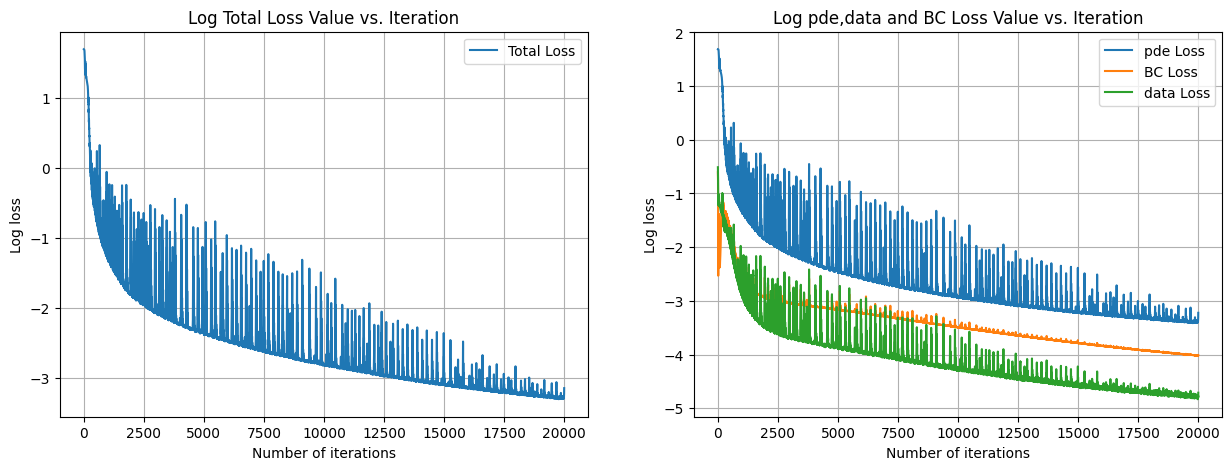

In [9]:
plot_loss(loss_trace, pde_trace, bc_trace, data_trace)

In [14]:
##compute the NN solutions
NN_solution, _ = model(X_grid.to('cuda'))
NN_solution = NN_solution[:, :, 0].cpu().detach().numpy()
NN_solution = [NN_solution[i, :].reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]

In [15]:
def relative_error(NN_solution, truth_solution):
  return abs(np.array(NN_solution) - np.array(truth_solution)).mean() / abs(np.array(truth_solution)).mean()

##report relative error
r_error = relative_error(NN_solution, truth_solution)
print("Relative Error: {}".format(r_error))

Relative Error: 0.005838730751882905


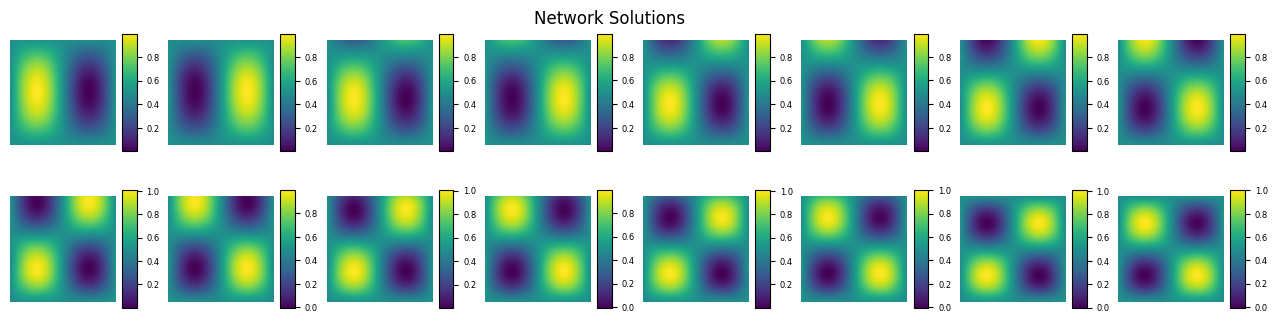

In [16]:
#plot the network solution
plot_solutions16(NN_solution, "Network Solutions")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
##go to the code folder where I can import the PDE_models module
%cd 'gdrive/MyDrive/PINN/PINN_program/code'

/content/gdrive/MyDrive/PINN/PINN_program/code


In [ ]:
##log and save the record
log = {
    'model': model,
    'optimizer':optimizer,
    'bias': True,
    'forcing_info': {
        'A': A_list,
        'K1': k1,
        'K2': K2,
        'b': b
    },
    'lr': learning_rate,
    'num_iter': num_iter,
    'step_size': step_size,
    'gamma': gamma,
    'interior_grid': interior_grid,
    'x_boundary_num': x_boundary_num,
    't_boundary_num': t_boundary_num,
    'boundary_value': b,
    'pde_weight': pde_weight,
    'bc_weight': bc_weight,
    'data_weight': data_weight,
    'loss_trace': {
        'total': loss_trace,
        'pde': pde_trace,
        'bc': bc_trace,
        'data': data_trace
    },
    'relative_error': r_error,
    'method': 'equally-spaced-noisy'
}

In [ ]:
import pickle
path = 'train/experiment_log/Fisher_16head_model_dec25_trig_1phase.pickle'
file = open(path, 'wb')
pickle.dump(model.cpu(), file)
file.close()

In [ ]:
import pickle
path = 'train/experiment_log/Fisher_16head_log_dec25_trig_1phase.pickle'
file = open(path, 'wb')
pickle.dump(log, file)
file.close()